Seed index: 102
Seed job  : data scientist @ company_193
--------------------------------------------------------------------------------

=== BASE top-10 ===
     job_title     company company_size_group  salary_max seniority_level                                                skills_clean  similarity
data scientist company_290              large     41758.0          senior             powerbi|aws|python|sql|machine learning|tableau    0.949591
data scientist company_357              large     22839.0          senior               aws|r|python|sql|gcp|machine learning|tableau    0.867780
data scientist company_251              large    156348.0          senior           aws|powerbi|r|python|sql|machine learning|tableau    0.866556
data scientist company_251              large    156350.0          senior           aws|powerbi|r|python|sql|machine learning|tableau    0.866550
data scientist company_318              large    100472.0          senior                               sql|mac

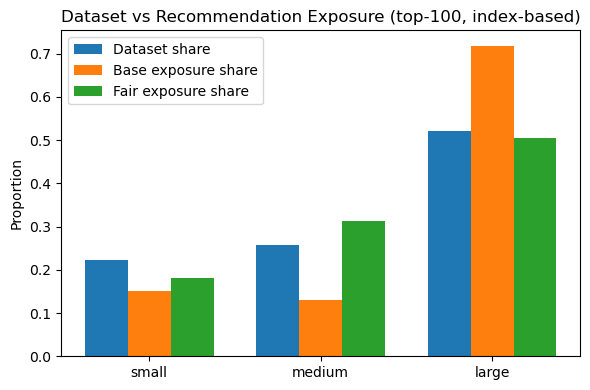

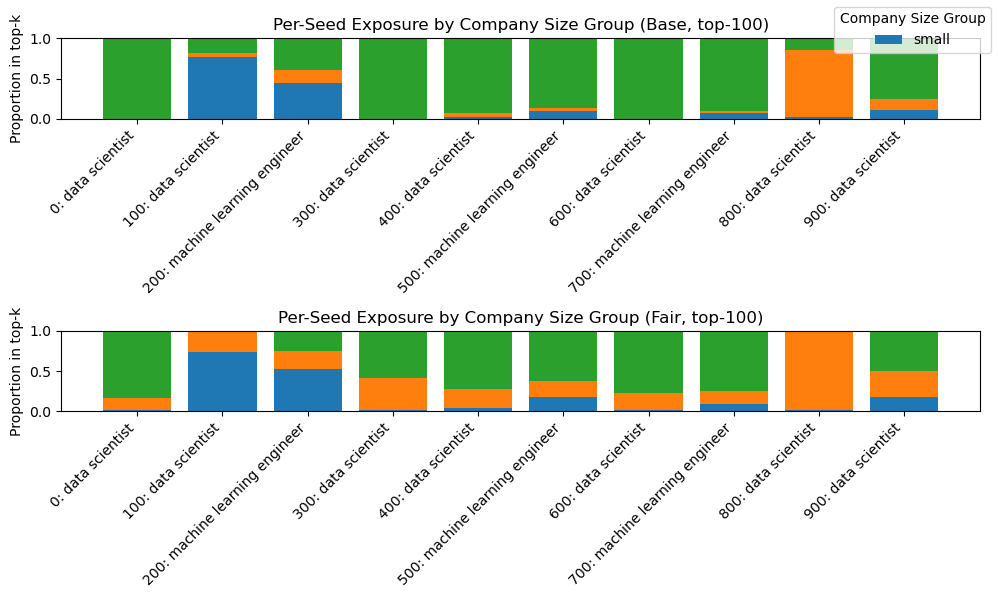

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# ============================================================
# 0. Load df + X_hybrid from saved embeddings
# ============================================================
df, X_hybrid = joblib.load("../data/hybrid_embeddings.pkl")

# Basic sanity checks
assert "company_size_group" in df.columns, "df must have company_size_group column"
assert X_hybrid.shape[0] == len(df), "X_hybrid rows must match df rows"

# ============================================================
# 1. Group weights for fairness re-weighting
# ============================================================
GROUP_WEIGHTS = {
    "small": 0.9,    # boost small companies
    "medium": 1.0,   # neutral
    "large": 0.75,   # slight down-weight
}

# Use only these groups in plots (ignore "unknown")
GROUP_ORDER = ["small", "medium", "large"]

# ============================================================
# 2. Base recommender: index -> similar jobs (no fairness)
# ============================================================
def search_jobs_base_by_index(job_idx, top_k=100):
    """
    Base recommender:
      - takes a seed job index
      - finds similar jobs using cosine similarity in X_hybrid
      - returns top_k jobs sorted by similarity
    """
    # Vector for the seed job
    q_vec = X_hybrid[job_idx]

    # Cosine similarity to all jobs
    sims = cosine_similarity(q_vec, X_hybrid).flatten()

    # Sort indices by similarity (descending)
    ranked_idx = np.argsort(-sims)

    # Build result dataframe
    results = df.iloc[ranked_idx].copy()
    results["similarity"] = sims[ranked_idx]

    # Remove the seed job itself
    results = results[results.index != job_idx]

    # Nice column order
    cols = [
        "job_title",
        "company",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity",
    ]
    cols = [c for c in cols if c in results.columns]

    return results[cols].head(top_k)

# ============================================================
# 3. Fairness re-weighting built on top of base recommender
# ============================================================
def reweight_fair_from_base(base_results, top_k=100):
    """
    Take base recommender output and apply fairness weights:
      fair_score = similarity * group_weight
    """
    fair = base_results.copy()

    # Drop jobs with unknown company size for fairness computation
    fair = fair[fair["company_size_group"] != "unknown"].copy()

    # Apply group weights
    fair["fair_weight"] = fair["company_size_group"].map(
        lambda g: GROUP_WEIGHTS.get(g, 1.0)
    )
    fair["fair_score"] = fair["similarity"] * fair["fair_weight"]

    # Sort by fair_score
    fair = fair.sort_values("fair_score", ascending=False).head(top_k)

    return fair


def search_jobs_fair_by_index(job_idx, top_k=100, candidate_k=None):
    """
    Fairness-aware recommender (index-based):

      1. Run base recommender to get candidate_k jobs.
      2. Re-weight scores using GROUP_WEIGHTS.
      3. Return top_k by fair_score.
    """
    if candidate_k is None:
        candidate_k = min(len(df) - 1, 500)  # cap for speed

    base_results = search_jobs_base_by_index(job_idx, top_k=candidate_k)
    fair_results = reweight_fair_from_base(base_results, top_k=top_k)
    return fair_results

# ============================================================
# 4. Sample output: compare base vs fair for a random seed
# ============================================================
np.random.seed(42)  # reproducible seed choice
seed_idx = np.random.randint(0, len(df))

print(f"Seed index: {seed_idx}")
print(f"Seed job  : {df.iloc[seed_idx]['job_title']} @ {df.iloc[seed_idx]['company']}")
print("-" * 80)

base_top10 = search_jobs_base_by_index(seed_idx, top_k=10)
fair_top10 = search_jobs_fair_by_index(seed_idx, top_k=10)

print("\n=== BASE top-10 ===")
print(base_top10.to_string(index=False))

print("\n=== FAIR (reweighted) top-10 ===")
print(fair_top10.to_string(index=False))

# ============================================================
# 5. Helper: compute dataset and recommendation exposure
# ============================================================
def compute_dataset_share():
    """
    Proportion of jobs in each company_size_group in the whole dataset.
    """
    mask = df["company_size_group"].isin(GROUP_ORDER)
    counts = df.loc[mask, "company_size_group"].value_counts().reindex(
        GROUP_ORDER, fill_value=0
    )
    return counts / counts.sum()


def compute_exposure(seeds, recommender_fn, top_k=100):
    """
    Compute:
      - overall exposure share per group (aggregated over all seeds)
      - per-seed exposure matrix (for stacked bar plot)

    seeds          : list of seed indices
    recommender_fn : function(job_idx, top_k) -> DataFrame of recs
    """
    total_counts = np.zeros(len(GROUP_ORDER), dtype=float)
    per_seed_props = []

    for job_idx in seeds:
        recs = recommender_fn(job_idx, top_k=top_k)

        # Keep only known groups
        recs = recs[recs["company_size_group"].isin(GROUP_ORDER)].copy()

        counts = recs["company_size_group"].value_counts().reindex(
            GROUP_ORDER, fill_value=0
        )
        total_counts += counts.values

        # Per-seed proportion (for stacked bar)
        if counts.sum() > 0:
            per_seed_props.append((counts / counts.sum()).values)
        else:
            per_seed_props.append(np.zeros(len(GROUP_ORDER)))

    total_share = total_counts / total_counts.sum()
    per_seed_matrix = np.vstack(per_seed_props)  # shape: (n_seeds, n_groups)
    return total_share, per_seed_matrix

# ============================================================
# 6. Choose seed jobs and compute exposures (your style)
# ============================================================
# Fixed seeds: every 100th job (trimmed to dataset size)
raw_seeds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
seed_indices = [i for i in raw_seeds if i < len(df)]
top_k = 100

dataset_share = compute_dataset_share()
base_share, base_per_seed = compute_exposure(
    seed_indices, search_jobs_base_by_index, top_k=top_k
)
fair_share, fair_per_seed = compute_exposure(
    seed_indices,
    lambda idx, top_k: search_jobs_fair_by_index(idx, top_k=top_k),
    top_k=top_k,
)

# ============================================================
# 7. Plot 1: Dataset vs Base vs Fair Exposure (top-k)
# ============================================================
x = np.arange(len(GROUP_ORDER))
width = 0.25

plt.figure(figsize=(6, 4))
plt.bar(x - width, dataset_share.values, width, label="Dataset share")
plt.bar(x,         base_share,           width, label="Base exposure share")
plt.bar(x + width, fair_share,           width, label="Fair exposure share")

plt.xticks(x, GROUP_ORDER)
plt.ylabel("Proportion")
plt.title("Dataset vs Recommendation Exposure (top-100, index-based)")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 8. Plot 2: Per-seed exposure (Base vs Fair, stacked bars, vertical)
# ============================================================
seed_labels = [
    f"{i}: {df.iloc[i]['job_title']}"
    for i in seed_indices
]

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)

# --- (a) Base recommender per-seed exposure ---
bottom = np.zeros(len(seed_indices))
for g_idx, group in enumerate(GROUP_ORDER):
    axes[0].bar(
        np.arange(len(seed_indices)),
        base_per_seed[:, g_idx],
        bottom=bottom,
        label=group if g_idx == 0 else None,
    )
    bottom += base_per_seed[:, g_idx]

axes[0].set_title("Per-Seed Exposure by Company Size Group (Base, top-100)")
axes[0].set_ylabel("Proportion in top-k")
axes[0].set_xticks(np.arange(len(seed_indices)))
axes[0].set_xticklabels(seed_labels, rotation=45, ha="right")

# --- (b) Fair recommender per-seed exposure ---
bottom = np.zeros(len(seed_indices))
for g_idx, group in enumerate(GROUP_ORDER):
    axes[1].bar(
        np.arange(len(seed_indices)),
        fair_per_seed[:, g_idx],
        bottom=bottom,
        label=group if g_idx == 0 else None,
    )
    bottom += fair_per_seed[:, g_idx]

axes[1].set_title("Per-Seed Exposure by Company Size Group (Fair, top-100)")
axes[1].set_ylabel("Proportion in top-k")
axes[1].set_xticks(np.arange(len(seed_indices)))
axes[1].set_xticklabels(seed_labels, rotation=45, ha="right")

# Common legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, GROUP_ORDER, title="Company Size Group", loc="upper right")

plt.tight_layout()
plt.show()


In [33]:
# ============================================================
# 4. Dense fairness: fair + max N jobs per company
# ============================================================
def search_jobs_fair_dense_by_index(
    job_idx,
    top_k=10,
    max_per_company=2,
    candidate_factor=5,
):
    """
    Dense Fairness recommender (index-based).

    Steps:
      1. Run the FAIR recommender to get a larger candidate set:
           candidate_k = top_k * candidate_factor  (e.g., 5x top_k).
         This list is already sorted by fair_score (best first).
      2. Greedily pick jobs from this list, allowing at most
         max_per_company jobs from each company.
      3. Return up to top_k jobs. If the constraint is very strict,
         you may get slightly fewer than top_k results.
    """
    # 1) Decide how many candidates to pull from the fair recommender
    candidate_k = min(len(df) - 1, top_k * candidate_factor)

    # 2) Get fair-ranked candidates (≈ 5 * top_k)
    #    IMPORTANT: we now start from FAIR, not BASE
    fair_candidates = search_jobs_fair_by_index(
        job_idx,
        top_k=candidate_k,
        candidate_k=candidate_k,
    )

    # 3) Greedy selection with per-company cap
    picked_rows = []
    per_company_count = {}

    for _, row in fair_candidates.iterrows():
        company = row.get("company", "unknown_company")
        if pd.isna(company):
            company = "unknown_company"

        # Skip if this company already hit the cap
        if per_company_count.get(company, 0) >= max_per_company:
            continue

        picked_rows.append(row)
        per_company_count[company] = per_company_count.get(company, 0) + 1

        if len(picked_rows) >= top_k:
            break

    # 4) Build final DataFrame
    if not picked_rows:
        # Empty but with correct columns
        return fair_candidates.head(0)

    final = pd.DataFrame(picked_rows)

    # Keep columns in a consistent order
    cols = [
        "job_title",
        "company",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity",
        "fair_weight",
        "fair_score",
    ]
    cols = [c for c in cols if c in final.columns]
    return final[cols]


In [34]:
dense_top10 = search_jobs_fair_dense_by_index(
    seed_idx,
    top_k=10,
    max_per_company=10,   # you can change this if needed
)

print("\n=== BASE top-10 ===")
print(base_top10.to_string(index=False))

print("\n=== FAIR (reweighted) top-10 ===")
print(fair_top10.to_string(index=False))

print("\n=== FAIR + DENSE (fair + max 2 per company) top-10 ===")
print(dense_top10.to_string(index=False))



=== BASE top-10 ===
     job_title     company company_size_group  salary_max seniority_level                                                skills_clean  similarity
data scientist company_290              large     41758.0          senior             powerbi|aws|python|sql|machine learning|tableau    0.949591
data scientist company_357              large     22839.0          senior               aws|r|python|sql|gcp|machine learning|tableau    0.867780
data scientist company_251              large    156348.0          senior           aws|powerbi|r|python|sql|machine learning|tableau    0.866556
data scientist company_251              large    156350.0          senior           aws|powerbi|r|python|sql|machine learning|tableau    0.866550
data scientist company_318              large    100472.0          senior                               sql|machine learning|r|python    0.864068
data scientist company_610              large     83821.0          senior             git|r|python|sql|

In [35]:
# ============================================================
# A. Seeds and exposure computation for all 3 recommenders
# ============================================================
# Fixed seeds: every 100th job (trimmed to dataset size)
raw_seeds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
seed_indices = [i for i in raw_seeds if i < len(df)]
top_k = 100  # exposure window

dataset_share = compute_dataset_share()

# Base exposure
base_share, base_per_seed = compute_exposure(
    seed_indices,
    search_jobs_base_by_index,
    top_k=top_k,
)

# Fair exposure
fair_share, fair_per_seed = compute_exposure(
    seed_indices,
    lambda idx, top_k: search_jobs_fair_by_index(idx, top_k=top_k),
    top_k=top_k,
)

# Dense (fair + max N per company) exposure
dense_share, dense_per_seed = compute_exposure(
    seed_indices,
    lambda idx, top_k: search_jobs_fair_dense_by_index(
        idx,
        top_k=top_k,
        max_per_company=2,   # you can tune this
        candidate_factor=5,
    ),
    top_k=top_k,
)


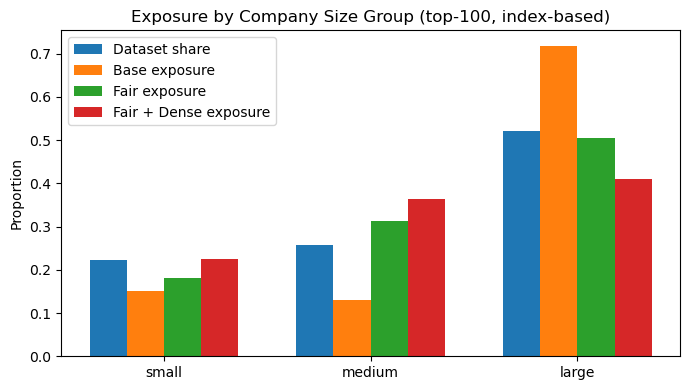

In [36]:
# ============================================================
# B. Plot 1: Dataset vs Base vs Fair vs Dense Exposure (top-k)
# ============================================================
x = np.arange(len(GROUP_ORDER))
width = 0.18

plt.figure(figsize=(7, 4))
plt.bar(x - 1.5 * width, dataset_share.values, width, label="Dataset share")
plt.bar(x - 0.5 * width, base_share,         width, label="Base exposure")
plt.bar(x + 0.5 * width, fair_share,         width, label="Fair exposure")
plt.bar(x + 1.5 * width, dense_share,        width, label="Fair + Dense exposure")

plt.xticks(x, GROUP_ORDER)
plt.ylabel("Proportion")
plt.title(f"Exposure by Company Size Group (top-{top_k}, index-based)")
plt.legend()
plt.tight_layout()
plt.show()


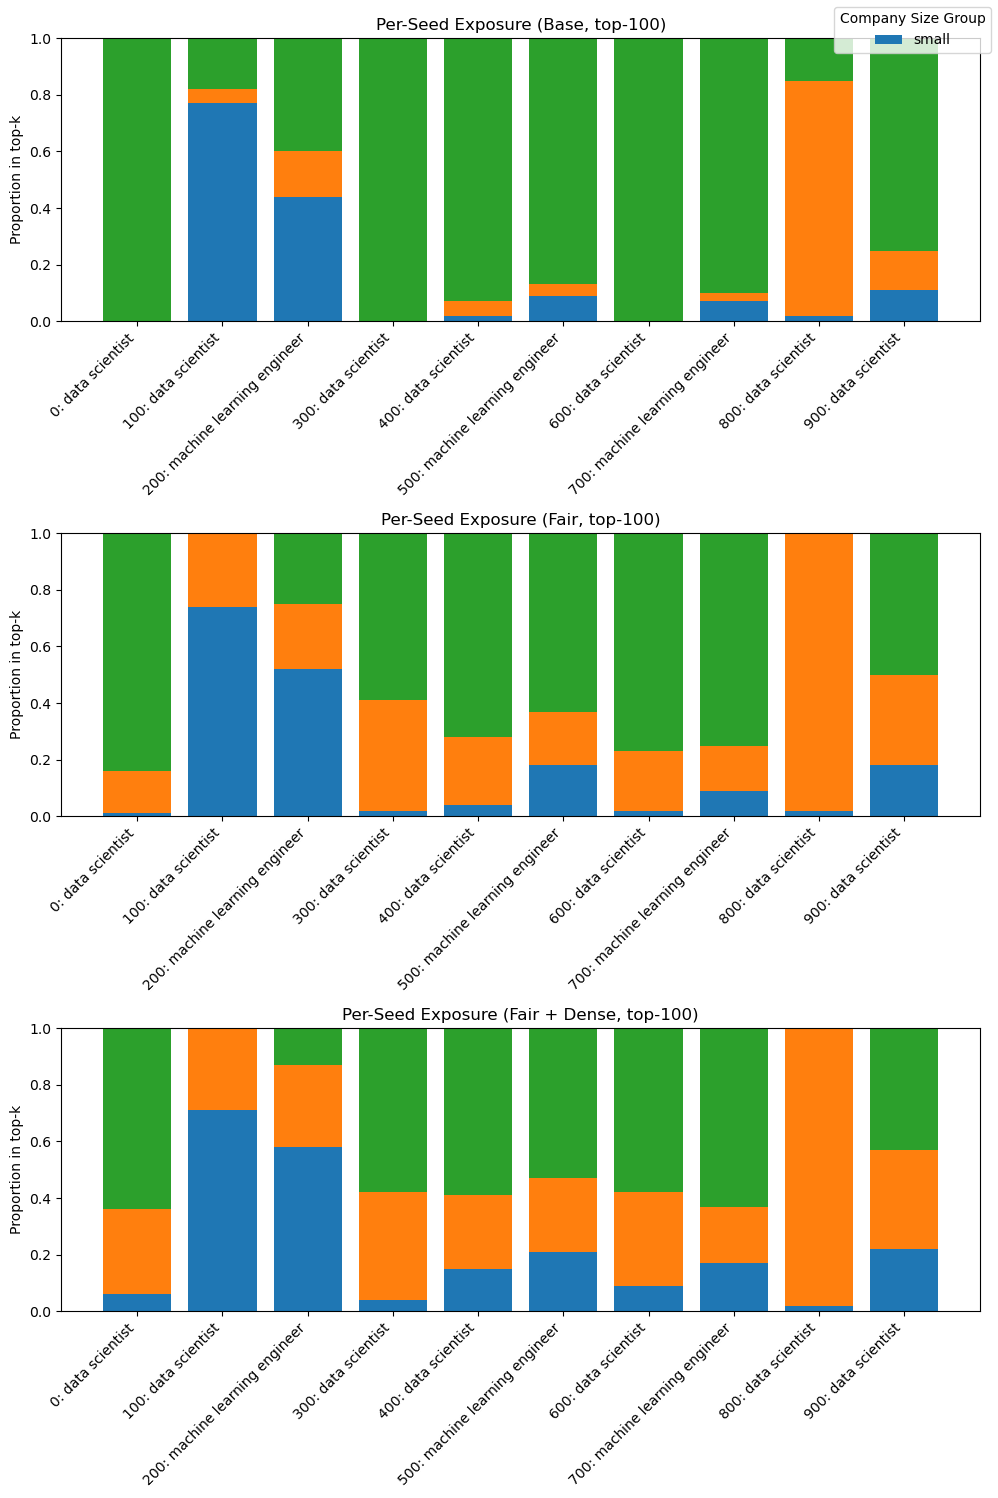

In [39]:
# ============================================================
# C. Plot 2: Per-seed exposure for 3 recommenders (vertical)
# ============================================================
seed_labels = [
    f"{i}: {df.iloc[i]['job_title']}"
    for i in seed_indices
]

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharey=True)

def plot_per_seed_stacked(ax, per_seed_matrix, title):
    bottom = np.zeros(len(seed_indices))
    for g_idx, group in enumerate(GROUP_ORDER):
        ax.bar(
            np.arange(len(seed_indices)),
            per_seed_matrix[:, g_idx],
            bottom=bottom,
            label=group if g_idx == 0 else None,
        )
        bottom += per_seed_matrix[:, g_idx]

    ax.set_title(title)
    ax.set_ylabel("Proportion in top-k")
    ax.set_xticks(np.arange(len(seed_indices)))
    ax.set_xticklabels(seed_labels, rotation=45, ha="right")

# --- (a) Base recommender per-seed exposure ---
plot_per_seed_stacked(
    axes[0],
    base_per_seed,
    f"Per-Seed Exposure (Base, top-{top_k})",
)

# --- (b) Fair recommender per-seed exposure ---
plot_per_seed_stacked(
    axes[1],
    fair_per_seed,
    f"Per-Seed Exposure (Fair, top-{top_k})",
)

# --- (c) Dense recommender per-seed exposure ---
plot_per_seed_stacked(
    axes[2],
    dense_per_seed,
    f"Per-Seed Exposure (Fair + Dense, top-{top_k})",
)

# Common legend
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, GROUP_ORDER, title="Company Size Group", loc="upper right")

plt.tight_layout()
plt.show()


Dataset group counts:
company_size_group
small     205
medium    239
large     481
Name: count, dtype: int64

Dataset group proportions:
company_size_group
small     0.221622
medium    0.258378
large     0.520000
Name: count, dtype: float64

==================== Base Recommender ====================

Selection counts per group:
company_size_group
small     152
medium    130
large     718
Name: count, dtype: int64

Selection Rate (SR) per group:
company_size_group
small     0.741463
medium    0.543933
large     1.492723
Name: count, dtype: float64

Rank-aware Exposure share per group:
company_size_group
small     0.159465
medium    0.127154
large     0.713382
Name: exposure_weight, dtype: float64

Proportional Fairness Error (PFE): 0.3868

Recommendation diversity (companies):
  Total recommendation slots:    1000
  Distinct companies recommended: 251
  Diversity ratio (distinct/slots): 0.2510
  Avg distinct companies per seed:  51.80

==================== Fair Recommender =============

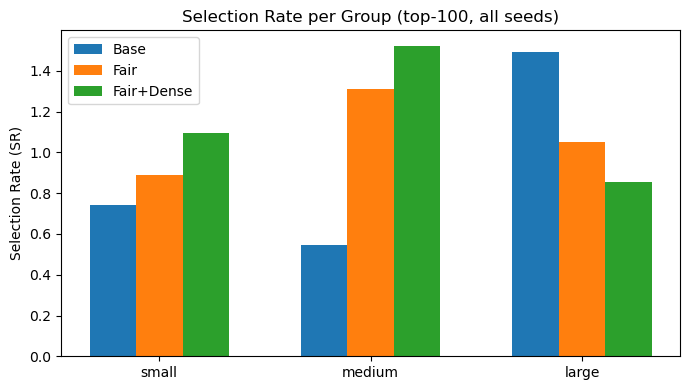

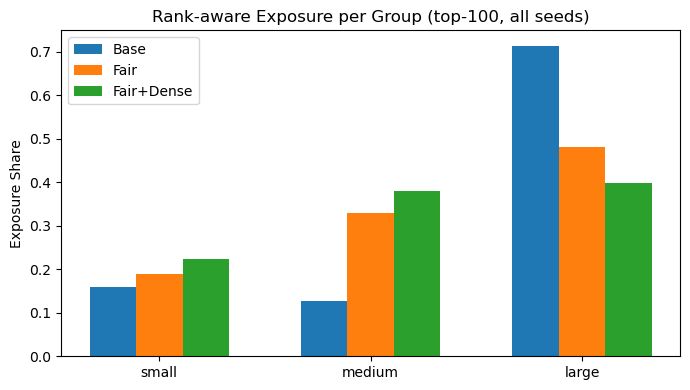

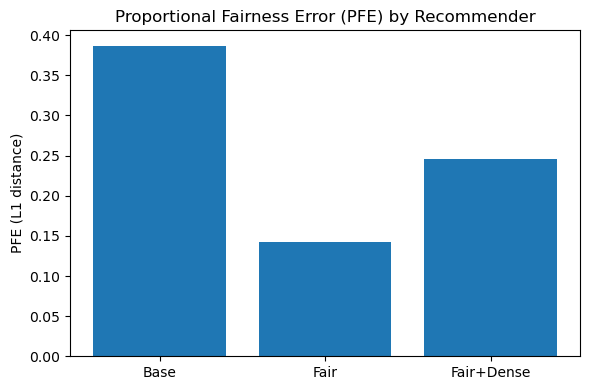

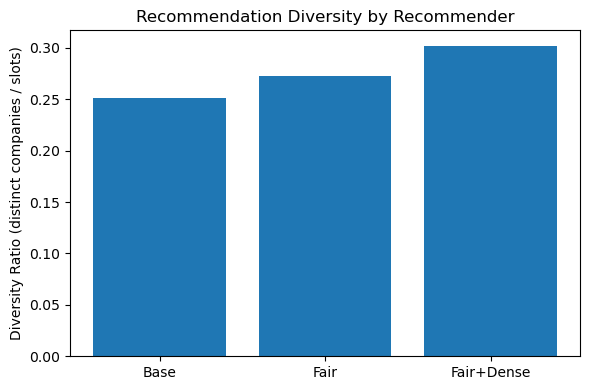

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. Global group info (dataset distribution)
# ============================================================
# Only use the main groups for fairness metrics
group_counts = df[df["company_size_group"].isin(GROUP_ORDER)]["company_size_group"] \
    .value_counts().reindex(GROUP_ORDER, fill_value=0)
dataset_share = group_counts / group_counts.sum()

print("Dataset group counts:")
print(group_counts)
print("\nDataset group proportions:")
print(dataset_share)

# ============================================================
# 2. Helper: collect all recs for a recommender across seeds
# ============================================================
def collect_recommendations(seeds, recommender_fn, top_k):
    """
    For a given recommender, run over all seed indices and
    collect a single DataFrame with columns:
      seed_idx, rank, company_size_group, company, ...
    """
    all_recs = []

    for job_idx in seeds:
        recs = recommender_fn(job_idx, top_k=top_k).copy()
        if recs.empty:
            continue

        recs["seed_idx"] = job_idx
        recs["rank"] = np.arange(1, len(recs) + 1)
        all_recs.append(recs)

    if not all_recs:
        return pd.DataFrame()

    return pd.concat(all_recs, ignore_index=True)

# If not already defined, set seeds and top_k for evaluation
raw_seeds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
seed_indices = [i for i in raw_seeds if i < len(df)]
top_k_eval = 100   # top-K window for fairness metrics

# ============================================================
# 3. Helper: compute all fairness metrics for a recommender
# ============================================================
def compute_fairness_metrics(all_recs, name="base"):
    """
    Given a combined recs DataFrame for all seeds, compute:
      - Selection Rate (SR) per group
      - Rank-aware Exposure share per group
      - PFE (L1 distance between exposure share and dataset share)
      - Recommendation Diversity (company-level)
    """
    if all_recs.empty:
        print(f"\n[{name}] No recommendations collected.")
        return None

    # Only keep the main groups
    mask = all_recs["company_size_group"].isin(GROUP_ORDER)
    recs = all_recs.loc[mask].copy()

    # ---------- 1) Selection Rate ----------
    # Numerator: how many times each group appears in top-K across all seeds
    sel_counts = recs["company_size_group"].value_counts().reindex(
        GROUP_ORDER, fill_value=0
    )

    # Denominator: how many jobs in that group in the dataset
    # (group_counts already computed)
    selection_rate = sel_counts / group_counts.replace(0, np.nan)

    # ---------- 2) Rank-aware Exposure ----------
    # Exposure weight = 1 / log2(rank + 1)
    recs["exposure_weight"] = 1.0 / np.log2(recs["rank"] + 1.0)

    exposure_by_group = recs.groupby("company_size_group")["exposure_weight"] \
        .sum().reindex(GROUP_ORDER, fill_value=0)

    exposure_share = exposure_by_group / exposure_by_group.sum()

    # ---------- 3) Proportional Fairness Error (PFE) ----------
    # Here: sum of absolute differences between exposure share and dataset share
    pfe = (exposure_share - dataset_share).abs().sum()

    # ---------- 4) Recommendation Diversity ----------
    # Company diversity: how many distinct companies vs total recommendation slots
    total_slots = len(recs)
    distinct_companies = recs["company"].nunique() if "company" in recs.columns else np.nan
    diversity_ratio = distinct_companies / total_slots if total_slots > 0 else np.nan

    # Also: average number of distinct companies per seed
    avg_companies_per_seed = recs.groupby("seed_idx")["company"].nunique().mean() \
        if "company" in recs.columns else np.nan

    metrics = {
        "name": name,
        "selection_rate": selection_rate,
        "sel_counts": sel_counts,
        "exposure_share": exposure_share,
        "exposure_by_group": exposure_by_group,
        "PFE": pfe,
        "distinct_companies": distinct_companies,
        "total_slots": total_slots,
        "diversity_ratio": diversity_ratio,
        "avg_companies_per_seed": avg_companies_per_seed,
    }
    return metrics

# ============================================================
# 4. Collect recommendations for all 3 recommenders
# ============================================================
base_recs  = collect_recommendations(seed_indices, search_jobs_base_by_index,  top_k_eval)
fair_recs  = collect_recommendations(seed_indices, search_jobs_fair_by_index,  top_k_eval)
dense_recs = collect_recommendations(
    seed_indices,
    lambda idx, top_k: search_jobs_fair_dense_by_index(
    idx,
    top_k=top_k,
    max_per_company=2,
    candidate_factor=5,
),
    top_k_eval,
)

# ============================================================
# 5. Compute metrics for Base, Fair, Dense
# ============================================================
base_metrics  = compute_fairness_metrics(base_recs,  name="Base")
fair_metrics  = compute_fairness_metrics(fair_recs,  name="Fair")
dense_metrics = compute_fairness_metrics(dense_recs, name="Fair+Dense")

# ============================================================
# 6. Print text summaries (assignment-friendly)
# ============================================================
def print_metrics_summary(m):
    print(f"\n==================== {m['name']} Recommender ====================")
    print("\nSelection counts per group:")
    print(m["sel_counts"])
    print("\nSelection Rate (SR) per group:")
    print(m["selection_rate"])

    print("\nRank-aware Exposure share per group:")
    print(m["exposure_share"])

    print(f"\nProportional Fairness Error (PFE): {m['PFE']:.4f}")

    print("\nRecommendation diversity (companies):")
    print(f"  Total recommendation slots:    {m['total_slots']}")
    print(f"  Distinct companies recommended: {m['distinct_companies']}")
    print(f"  Diversity ratio (distinct/slots): {m['diversity_ratio']:.4f}")
    print(f"  Avg distinct companies per seed:  {m['avg_companies_per_seed']:.2f}")

print_metrics_summary(base_metrics)
print_metrics_summary(fair_metrics)
print_metrics_summary(dense_metrics)

# ============================================================
# 7. Plots: SR, Exposure share, PFE, Diversity
# ============================================================

# Helper to stack metrics into arrays for plotting
sr_base  = base_metrics["selection_rate"].values
sr_fair  = fair_metrics["selection_rate"].values
sr_dense = dense_metrics["selection_rate"].values

exp_base  = base_metrics["exposure_share"].values
exp_fair  = fair_metrics["exposure_share"].values
exp_dense = dense_metrics["exposure_share"].values

pfe_vals = [
    base_metrics["PFE"],
    fair_metrics["PFE"],
    dense_metrics["PFE"],
]

div_vals = [
    base_metrics["diversity_ratio"],
    fair_metrics["diversity_ratio"],
    dense_metrics["diversity_ratio"],
]

labels_rec = ["Base", "Fair", "Fair+Dense"]

# ---------- Plot A: Selection Rate per group ----------
x = np.arange(len(GROUP_ORDER))
width = 0.22

plt.figure(figsize=(7, 4))
plt.bar(x - width,      sr_base,  width, label="Base")
plt.bar(x,              sr_fair,  width, label="Fair")
plt.bar(x + width,      sr_dense, width, label="Fair+Dense")

plt.xticks(x, GROUP_ORDER)
plt.ylabel("Selection Rate (SR)")
plt.title(f"Selection Rate per Group (top-{top_k_eval}, all seeds)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot B: Rank-aware Exposure share ----------
plt.figure(figsize=(7, 4))
plt.bar(x - width,      exp_base,  width, label="Base")
plt.bar(x,              exp_fair,  width, label="Fair")
plt.bar(x + width,      exp_dense, width, label="Fair+Dense")

plt.xticks(x, GROUP_ORDER)
plt.ylabel("Exposure Share")
plt.title(f"Rank-aware Exposure per Group (top-{top_k_eval}, all seeds)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot C: PFE per recommender ----------
plt.figure(figsize=(6, 4))
plt.bar(labels_rec, pfe_vals)
plt.ylabel("PFE (L1 distance)")
plt.title("Proportional Fairness Error (PFE) by Recommender")
plt.tight_layout()
plt.show()

# ---------- Plot D: Diversity ratio per recommender ----------
plt.figure(figsize=(6, 4))
plt.bar(labels_rec, div_vals)
plt.ylabel("Diversity Ratio (distinct companies / slots)")
plt.title("Recommendation Diversity by Recommender")
plt.tight_layout()
plt.show()
